In [168]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [169]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [170]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243781 entries, 0 to 2243780
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 34.2 MB


# reduce to 1 million events

In [171]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [172]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,28719,0.12,28.719
1,28605,0.12,28.605
2,29064,0.12,29.064
3,29157,0.12,29.157
4,29147,0.12,29.147
...,...,...,...
999995,29316,0.12,29.316
999996,29372,0.12,29.372
999997,29424,0.12,29.424
999998,27943,0.13,27.943


In [173]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [174]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [175]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26064092702000

### Calcul de la date de base = now - cumul_interval

In [176]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 25, 21, 5, 7, 5334)

In [177]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [178]:
conso_data.iloc[0]


Interval     28719.000000
kWh              0.120000
sec             28.719000
Wh             125.352554
cumul(ms)    28719.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [179]:
base

datetime.datetime(2024, 7, 25, 21, 5, 7, 5334)

## créer les dates

In [180]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-25 21:05:35.724334
1        2024-07-25 21:06:04.329334
2        2024-07-25 21:06:33.393334
3        2024-07-25 21:07:02.550334
4        2024-07-25 21:07:31.697334
                    ...            
999995   2025-05-23 13:04:44.957334
999996   2025-05-23 13:05:14.329334
999997   2025-05-23 13:05:43.753334
999998   2025-05-23 13:06:11.696334
999999   2025-05-23 13:06:39.707334
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [181]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,28719,0.12,28.719,125.352554,28719,2024-07-25 21:05:35.724334,25/07/24
1,28605,0.12,28.605,125.852124,57324,2024-07-25 21:06:04.329334,25/07/24
2,29064,0.12,29.064,123.864575,86388,2024-07-25 21:06:33.393334,25/07/24
3,29157,0.12,29.157,123.469493,115545,2024-07-25 21:07:02.550334,25/07/24
4,29147,0.12,29.147,123.511854,144692,2024-07-25 21:07:31.697334,25/07/24
...,...,...,...,...,...,...,...
999995,29316,0.12,29.316,122.799836,26063977952,2025-05-23 13:04:44.957334,23/05/25
999996,29372,0.12,29.372,122.565709,26064007324,2025-05-23 13:05:14.329334,23/05/25
999997,29424,0.12,29.424,122.349103,26064036748,2025-05-23 13:05:43.753334,23/05/25
999998,27943,0.13,27.943,128.833697,26064064691,2025-05-23 13:06:11.696334,23/05/25


### save conso_data with dates

In [182]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [183]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('23/05/25', 23, 5, 2025, '13:07:02')

In [184]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [185]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1529 entries, 998471 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1529 non-null   int64         
 1   kWh        1529 non-null   float64       
 2   sec        1529 non-null   float64       
 3   Wh         1529 non-null   float64       
 4   cumul(ms)  1529 non-null   int64         
 5   dates      1529 non-null   datetime64[ns]
 6   days       1529 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 95.6+ KB


In [186]:
end = time.time()
print(end - start)

27.92720866203308


### grouped by days

In [187]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [188]:
data = list(df_grp['kWh'])
print(data)

[0.418, 3.249, 3.202, 2.846, 3.054, 3.201, 4.193, 3.876, 2.997, 3.321, 3.344, 3.511, 3.643, 3.492, 3.683, 3.723, 3.922, 3.653, 4.377, 4.316, 3.911, 3.875, 4.043, 3.778, 3.867, 3.704, 3.285, 3.92, 3.956, 4.375, 3.844, 4.105, 3.798, 3.974, 3.75, 3.981, 3.657, 3.656, 3.495, 3.683, 3.503, 4.146, 3.715, 3.441, 3.565, 3.222, 2.474, 1.794, 1.793, 1.793, 1.796, 2.474, 1.864, 1.788, 1.791, 1.79, 1.821, 1.822, 1.814, 1.817, 1.819, 1.818, 1.815, 1.814, 1.785, 1.786, 1.785, 1.787, 1.782, 1.796, 1.789, 1.79, 1.785, 1.795, 1.803, 1.795, 1.803, 1.796, 1.786, 1.789, 1.785, 1.79, 1.798, 1.79, 1.801, 1.803, 1.795, 1.8, 1.798, 2.776, 4.0, 3.657, 3.897, 3.105, 3.542, 4.049, 3.43, 3.37, 3.983, 3.341, 4.167, 3.089, 4.033, 3.154, 3.347, 3.474, 4.014, 3.289, 3.372, 3.824, 3.227, 3.525, 3.363, 3.876, 3.332, 3.444, 3.702, 4.468, 3.645, 3.844, 3.452, 4.102, 3.498, 3.412, 3.435, 3.738, 3.734, 4.068, 3.546, 3.467, 3.704, 3.162, 3.683, 3.746, 3.329, 3.842, 3.252, 4.045, 3.393, 3.836, 3.98, 3.474, 4.475, 3.205, 3.53

In [189]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [190]:
end = time.time()
print(end - start)

29.107683181762695


### plot function by day
#### show('dd/mm/yy')

In [191]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


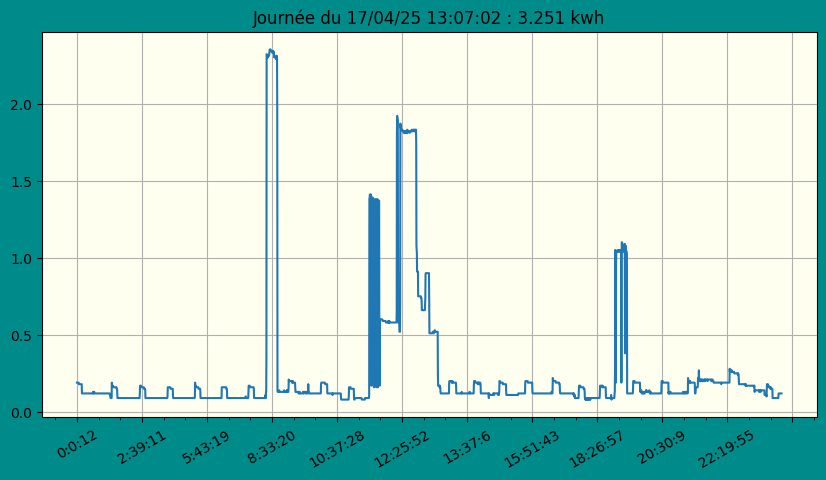

In [192]:
show('17/04/25')

In [193]:
end = time.time()
print(end - start)

31.682833909988403


### 1 kWh window in data of one day
#### df = conso_day

In [194]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998471,28622,0.12,28.622,125.777374,26016914082,2025-05-23 00:00:21.087334,23/05/25
998472,27171,0.13,27.171,132.494203,26016941253,2025-05-23 00:00:48.258334,23/05/25
998473,27207,0.13,27.207,132.318889,26016968460,2025-05-23 00:01:15.465334,23/05/25
998474,28278,0.13,28.278,127.307447,26016996738,2025-05-23 00:01:43.743334,23/05/25
998475,28437,0.13,28.437,126.595632,26017025175,2025-05-23 00:02:12.180334,23/05/25
...,...,...,...,...,...,...,...
999995,29316,0.12,29.316,122.799836,26063977952,2025-05-23 13:04:44.957334,23/05/25
999996,29372,0.12,29.372,122.565709,26064007324,2025-05-23 13:05:14.329334,23/05/25
999997,29424,0.12,29.424,122.349103,26064036748,2025-05-23 13:05:43.753334,23/05/25
999998,27943,0.13,27.943,128.833697,26064064691,2025-05-23 13:06:11.696334,23/05/25


In [195]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [196]:
df = conso_day
len(df)

1529

In [197]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-23 00:00:21.087334	2025-05-23 09:16:58.848334	9h 16m 37s 	1000
2025-05-23 09:16:58.848334	2025-05-23 13:06:39.707334	3h 49m 40s 	529


In [198]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.302393
dtype: float64

In [199]:
end = time.time()
print(end - start)

32.35699677467346


## mean for data grouped by days

In [200]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [201]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.529)

# conso by date


In [202]:
# select day
day = today

#day = '16/08/24'
day

'23/05/25'

In [203]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998471,28622,0.12,28.622,125.777374,26016914082,2025-05-23 00:00:21.087334,23/05/25
998472,27171,0.13,27.171,132.494203,26016941253,2025-05-23 00:00:48.258334,23/05/25
998473,27207,0.13,27.207,132.318889,26016968460,2025-05-23 00:01:15.465334,23/05/25
998474,28278,0.13,28.278,127.307447,26016996738,2025-05-23 00:01:43.743334,23/05/25
998475,28437,0.13,28.437,126.595632,26017025175,2025-05-23 00:02:12.180334,23/05/25
...,...,...,...,...,...,...,...
999995,29316,0.12,29.316,122.799836,26063977952,2025-05-23 13:04:44.957334,23/05/25
999996,29372,0.12,29.372,122.565709,26064007324,2025-05-23 13:05:14.329334,23/05/25
999997,29424,0.12,29.424,122.349103,26064036748,2025-05-23 13:05:43.753334,23/05/25
999998,27943,0.13,27.943,128.833697,26064064691,2025-05-23 13:06:11.696334,23/05/25


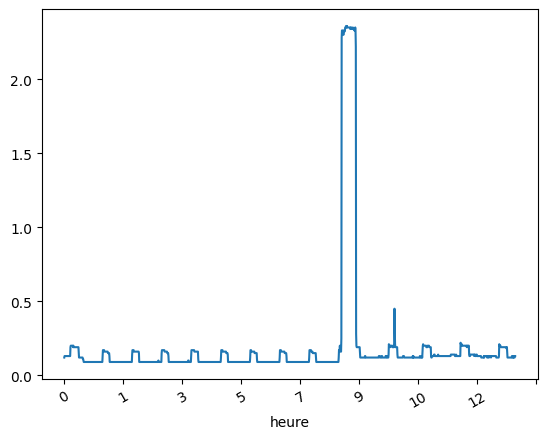

In [204]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [205]:
end = time.time()
print(end - start)

33.42811846733093


### grouped by 'heure'

In [206]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1529 entries, 998471 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1529 non-null   int64         
 1   kWh        1529 non-null   float64       
 2   sec        1529 non-null   float64       
 3   Wh         1529 non-null   float64       
 4   cumul(ms)  1529 non-null   int64         
 5   dates      1529 non-null   datetime64[ns]
 6   days       1529 non-null   object        
 7   heure      1529 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 107.5+ KB


In [207]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998471,28622,0.12,28.622,125.777374,26016914082,2025-05-23 00:00:21.087334,23/05/25
998472,27171,0.13,27.171,132.494203,26016941253,2025-05-23 00:00:48.258334,23/05/25
998473,27207,0.13,27.207,132.318889,26016968460,2025-05-23 00:01:15.465334,23/05/25
998474,28278,0.13,28.278,127.307447,26016996738,2025-05-23 00:01:43.743334,23/05/25
998475,28437,0.13,28.437,126.595632,26017025175,2025-05-23 00:02:12.180334,23/05/25
...,...,...,...,...,...,...,...
999995,29316,0.12,29.316,122.799836,26063977952,2025-05-23 13:04:44.957334,23/05/25
999996,29372,0.12,29.372,122.565709,26064007324,2025-05-23 13:05:14.329334,23/05/25
999997,29424,0.12,29.424,122.349103,26064036748,2025-05-23 13:05:43.753334,23/05/25
999998,27943,0.13,27.943,128.833697,26064064691,2025-05-23 13:06:11.696334,23/05/25


In [208]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [209]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     117
1     101
2     100
3     101
4     102
5      99
6      99
7      98
8     100
9     171
10    142
11    147
12    138
13     14
Name: kWh, dtype: int64

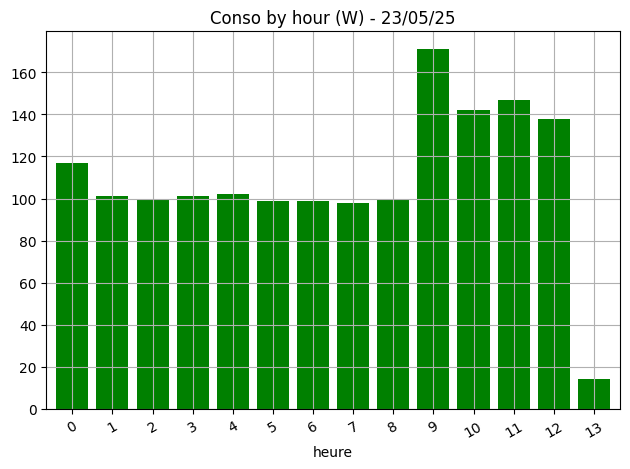

In [210]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [211]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 25/07/24 to 23/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [212]:
# give the periods of 1 kwh in a day
period()

2025-05-23 00:00:21.087334	2025-05-23 09:16:58.848334	9h 16m 37s 	1000


In [213]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [214]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [215]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [216]:
df_grp.head()


,kWh
days,
25/07/24,0.418
26/07/24,3.249
27/07/24,3.202
28/07/24,2.846
29/07/24,3.054


In [217]:
df_grp.tail()


,kWh
days,
19/05/25,3.296
20/05/25,2.998
21/05/25,3.015
22/05/25,3.246
23/05/25,1.529


In [218]:
end = time.time()
print(end - start)

35.12210750579834


# plot les 100 derniers jours


In [219]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.38186
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

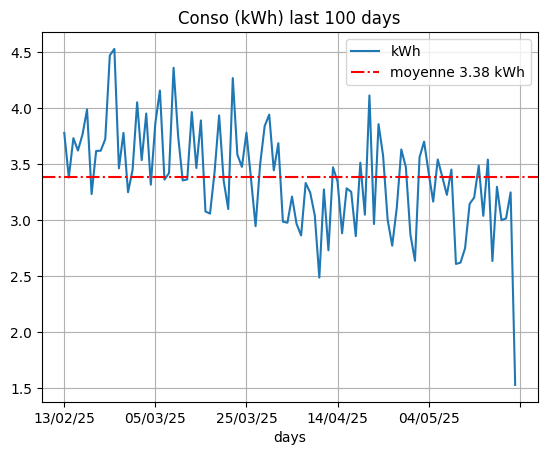

In [220]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [221]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.529
max,4.526


In [222]:
end = time.time()
print(end - start)

35.71640706062317


In [223]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('23/04/25', '18/05/25')

In [224]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.1976
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

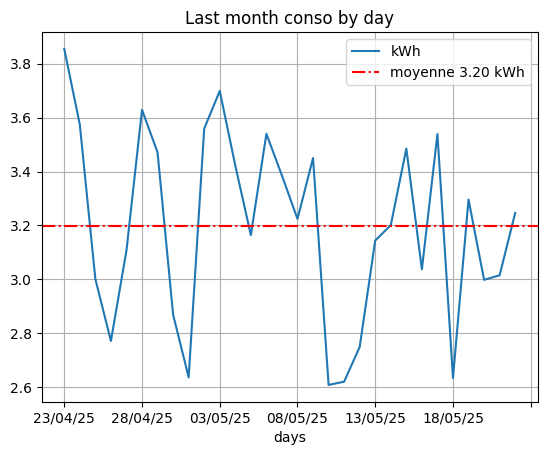

In [225]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [226]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/04/25 3.855
Min : 10/05/25 2.608


# Temps de conso par tranche de 1 kWh

In [227]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-05-23 00:00:21.087334	2025-05-23 09:16:58.848334	9h 16m 37s 	1000
2025-05-23 09:16:58.848334	2025-05-23 13:06:39.707334	3h 49m 40s 	529


In [228]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('13:07:02', 1.529, 1529)

In [229]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1529 entries, 998471 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1529 non-null   int64         
 1   kWh        1529 non-null   float64       
 2   sec        1529 non-null   float64       
 3   Wh         1529 non-null   float64       
 4   cumul(ms)  1529 non-null   int64         
 5   dates      1529 non-null   datetime64[ns]
 6   days       1529 non-null   object        
 7   heure      1529 non-null   object        
 8   hours      1529 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 119.5+ KB


In [230]:
conso_hours['heure'], conso_hours['hours']

(998471     0
 998472     0
 998473     0
 998474     0
 998475     0
           ..
 999995    13
 999996    13
 999997    13
 999998    13
 999999    13
 Name: heure, Length: 1529, dtype: object,
 998471    00
 998472    00
 998473    00
 998474    00
 998475    00
           ..
 999995    13
 999996    13
 999997    13
 999998    13
 999999    13
 Name: hours, Length: 1529, dtype: object)

In [231]:
end = time.time()
print(end - start)

37.1679105758667


# select number of days to display


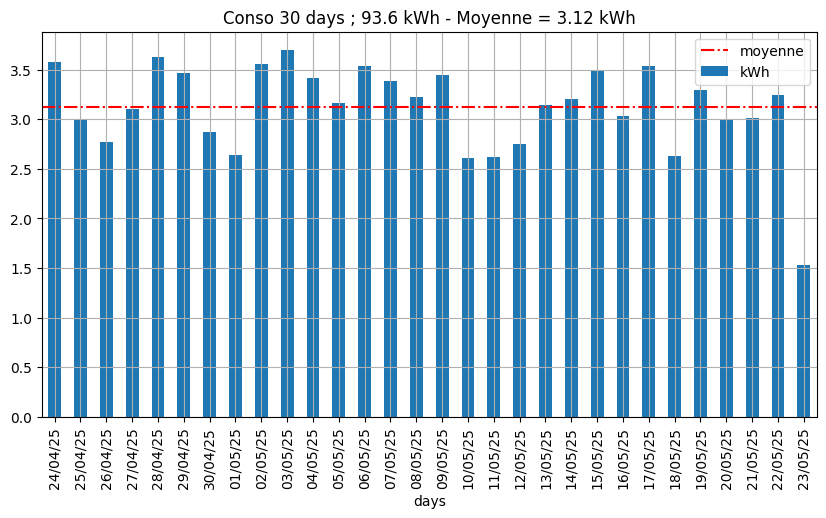

In [232]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


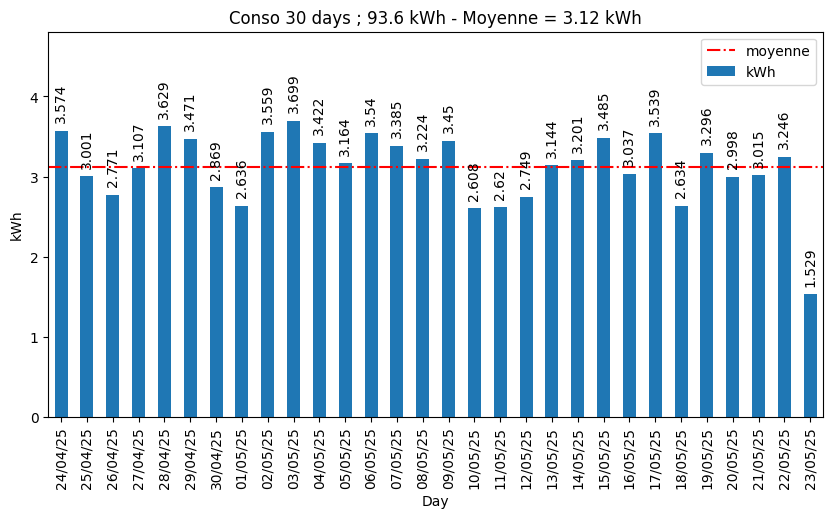

In [233]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [234]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
24/04/25    3.574
25/04/25    3.001
26/04/25    2.771
27/04/25    3.107
28/04/25    3.629
29/04/25    3.471
30/04/25    2.869
01/05/25    2.636
02/05/25    3.559
03/05/25    3.699
04/05/25    3.422
05/05/25    3.164
06/05/25    3.540
07/05/25    3.385
08/05/25    3.224
09/05/25    3.450
10/05/25    2.608
11/05/25    2.620
12/05/25    2.749
13/05/25    3.144
14/05/25    3.201
15/05/25    3.485
16/05/25    3.037
17/05/25    3.539
18/05/25    2.634
19/05/25    3.296
20/05/25    2.998
21/05/25    3.015
22/05/25    3.246
23/05/25    1.529
Name: kWh, dtype: float64

In [235]:
x_labels=df_grp.tail(span).index
x_labels

Index(['24/04/25', '25/04/25', '26/04/25', '27/04/25', '28/04/25', '29/04/25',
       '30/04/25', '01/05/25', '02/05/25', '03/05/25', '04/05/25', '05/05/25',
       '06/05/25', '07/05/25', '08/05/25', '09/05/25', '10/05/25', '11/05/25',
       '12/05/25', '13/05/25', '14/05/25', '15/05/25', '16/05/25', '17/05/25',
       '18/05/25', '19/05/25', '20/05/25', '21/05/25', '22/05/25', '23/05/25'],
      dtype='object', name='days')

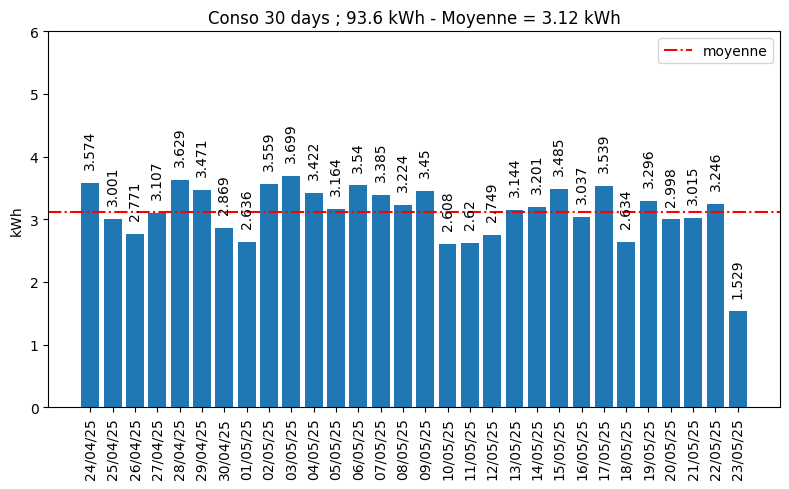

In [236]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [237]:
end = time.time()
print(end - start)

42.277403116226196


In [238]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

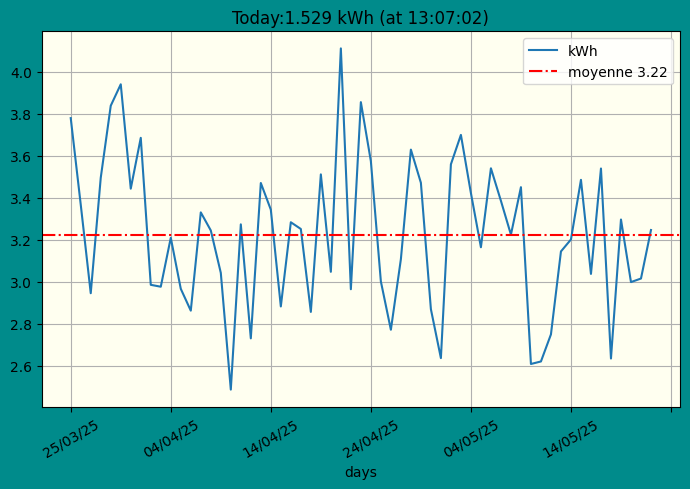

In [239]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

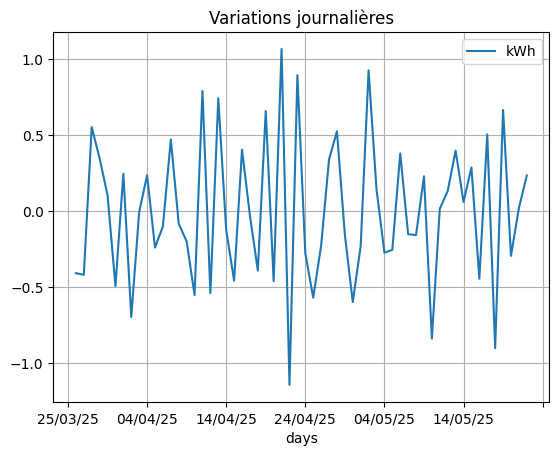

In [240]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [241]:
end = time.time()
print(end - start)

43.82380151748657


# Data from 21/08/23

In [242]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,28719,0.12,28.719,125.352554,28719,2024-07-25 21:05:35.724334,25/07/24,21,2024-07,25
1,28605,0.12,28.605,125.852124,57324,2024-07-25 21:06:04.329334,25/07/24,21,2024-07,25
2,29064,0.12,29.064,123.864575,86388,2024-07-25 21:06:33.393334,25/07/24,21,2024-07,25
3,29157,0.12,29.157,123.469493,115545,2024-07-25 21:07:02.550334,25/07/24,21,2024-07,25
4,29147,0.12,29.147,123.511854,144692,2024-07-25 21:07:31.697334,25/07/24,21,2024-07,25
...,...,...,...,...,...,...,...,...,...,...
999995,29316,0.12,29.316,122.799836,26063977952,2025-05-23 13:04:44.957334,23/05/25,13,2025-05,23
999996,29372,0.12,29.372,122.565709,26064007324,2025-05-23 13:05:14.329334,23/05/25,13,2025-05,23
999997,29424,0.12,29.424,122.349103,26064036748,2025-05-23 13:05:43.753334,23/05/25,13,2025-05,23
999998,27943,0.13,27.943,128.833697,26064064691,2025-05-23 13:06:11.696334,23/05/25,13,2025-05,23


In [243]:
end = time.time()
print(end - start)

86.64116907119751


In [244]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

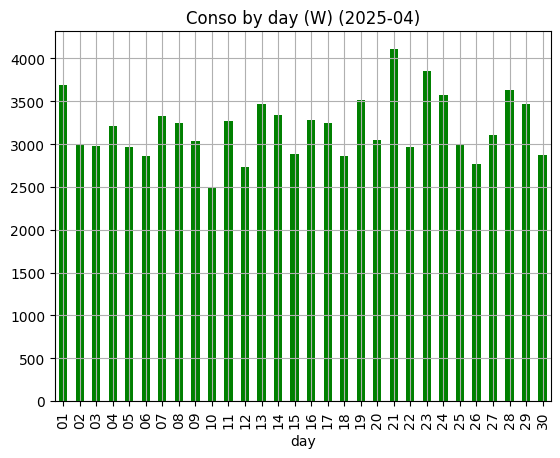

In [245]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [246]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3192.766666666667)

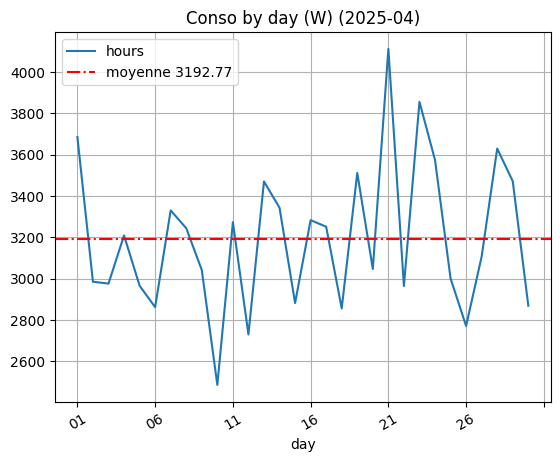

In [247]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [248]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

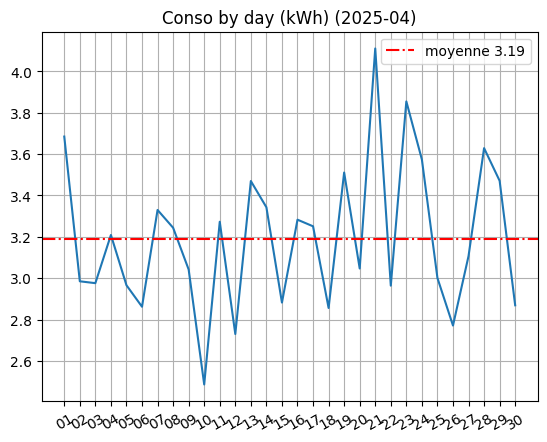

In [249]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [250]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [251]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [252]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,20163,20163,20163
2024-08,117337,117337,117337
2024-09,69810,69810,69810
2024-10,73478,73478,73478
2024-11,108515,108515,108515
2024-12,113724,113724,113724
2025-01,113685,113685,113685
2025-02,104469,104469,104469
2025-03,111856,111856,111856


In [253]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [254]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [255]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
25/07/24,418
26/07/24,3249
27/07/24,3202
28/07/24,2846
29/07/24,3054
...,...
19/05/25,3296
20/05/25,2998
21/05/25,3015


In [256]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,28719,0.12,28.719,125.352554,28719,2024-07-25 21:05:35.724334,25/07/24,21,2024-07,25
1,28605,0.12,28.605,125.852124,57324,2024-07-25 21:06:04.329334,25/07/24,21,2024-07,25
2,29064,0.12,29.064,123.864575,86388,2024-07-25 21:06:33.393334,25/07/24,21,2024-07,25
3,29157,0.12,29.157,123.469493,115545,2024-07-25 21:07:02.550334,25/07/24,21,2024-07,25
4,29147,0.12,29.147,123.511854,144692,2024-07-25 21:07:31.697334,25/07/24,21,2024-07,25
...,...,...,...,...,...,...,...,...,...,...
999995,29316,0.12,29.316,122.799836,26063977952,2025-05-23 13:04:44.957334,23/05/25,13,2025-05,23
999996,29372,0.12,29.372,122.565709,26064007324,2025-05-23 13:05:14.329334,23/05/25,13,2025-05,23
999997,29424,0.12,29.424,122.349103,26064036748,2025-05-23 13:05:43.753334,23/05/25,13,2025-05,23
999998,27943,0.13,27.943,128.833697,26064064691,2025-05-23 13:06:11.696334,23/05/25,13,2025-05,23


In [257]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
25/07/24 21    0       25/07/24    21  0.12
               1       25/07/24    21  0.12
               2       25/07/24    21  0.12
               3       25/07/24    21  0.12
               4       25/07/24    21  0.12
...                         ...   ...   ...
23/05/25 13    999995  23/05/25    13  0.12
               999996  23/05/25    13  0.12
               999997  23/05/25    13  0.12
               999998  23/05/25    13  0.13
               999999  23/05/25    13  0.13

[1000000 rows x 3 columns]

In [258]:
groupallbyday.indices.keys()

dict_keys(['25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/1

In [259]:
groupallbydayhours.indices.keys()

dict_keys([('25/07/24', '21'), ('25/07/24', '22'), ('25/07/24', '23'), ('26/07/24', '21'), ('26/07/24', '22'), ('26/07/24', '23'), ('26/07/24', '00'), ('26/07/24', '01'), ('26/07/24', '02'), ('26/07/24', '03'), ('26/07/24', '04'), ('26/07/24', '05'), ('26/07/24', '06'), ('26/07/24', '07'), ('26/07/24', '08'), ('26/07/24', '09'), ('26/07/24', '10'), ('26/07/24', '11'), ('26/07/24', '12'), ('26/07/24', '13'), ('26/07/24', '14'), ('26/07/24', '15'), ('26/07/24', '16'), ('26/07/24', '17'), ('26/07/24', '18'), ('26/07/24', '19'), ('26/07/24', '20'), ('27/07/24', '21'), ('27/07/24', '22'), ('27/07/24', '23'), ('27/07/24', '00'), ('27/07/24', '01'), ('27/07/24', '02'), ('27/07/24', '03'), ('27/07/24', '04'), ('27/07/24', '05'), ('27/07/24', '06'), ('27/07/24', '07'), ('27/07/24', '08'), ('27/07/24', '09'), ('27/07/24', '10'), ('27/07/24', '11'), ('27/07/24', '12'), ('27/07/24', '13'), ('27/07/24', '14'), ('27/07/24', '15'), ('27/07/24', '16'), ('27/07/24', '17'), ('27/07/24', '18'), ('27/07/2

In [260]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
25/07/24,418,418
26/07/24,3249,3249
27/07/24,3202,3202
28/07/24,2846,2846
29/07/24,3054,3054
...,...,...
19/05/25,3296,3296
20/05/25,2998,2998
21/05/25,3015,3015


In [261]:
grp_by_day['kWh'].cumsum()

days
25/07/24        418
26/07/24       3667
27/07/24       6869
28/07/24       9715
29/07/24      12769
             ...   
19/05/25     989212
20/05/25     992210
21/05/25     995225
22/05/25     998471
23/05/25    1000000
Name: kWh, Length: 303, dtype: int64

In [262]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
25/07/24 21     130
         22     140
         23     148
26/07/24 00     149
         01     147
...             ...
23/05/25 09     171
         10     142
         11     147
         12     138
         13      14

[7241 rows x 1 columns]

In [263]:
grp_by_dayhours['kWh'].cumsum()

days      hours
25/07/24  21           130
          22           270
          23           418
26/07/24  00           567
          01           714
                    ...   
23/05/25  09        999559
          10        999701
          11        999848
          12        999986
          13       1000000
Name: kWh, Length: 7241, dtype: int64

In [264]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
25/07/24 21     130     130    NaN
         22     140     270   10.0
         23     148     418    8.0
26/07/24 00     149     149    NaN
         01     147     296   -2.0
...             ...     ...    ...
23/05/25 09     171    1088   71.0
         10     142    1230  -29.0
         11     147    1377    5.0
         12     138    1515   -9.0
         13      14    1529 -124.0

[7241 rows x 3 columns]

In [265]:
today, grp_by_dayhours.loc[today]

('23/05/25',
        kWh  cumsum   diff
 hours                    
 00     117     117    NaN
 01     101     218  -16.0
 02     100     318   -1.0
 03     101     419    1.0
 04     102     521    1.0
 05      99     620   -3.0
 06      99     719    0.0
 07      98     817   -1.0
 08     100     917    2.0
 09     171    1088   71.0
 10     142    1230  -29.0
 11     147    1377    5.0
 12     138    1515   -9.0
 13      14    1529 -124.0)

Text(0.5, 1.0, 'Cumul journalier')

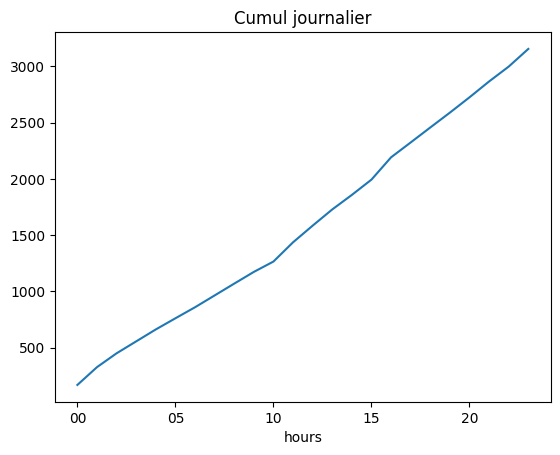

In [266]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

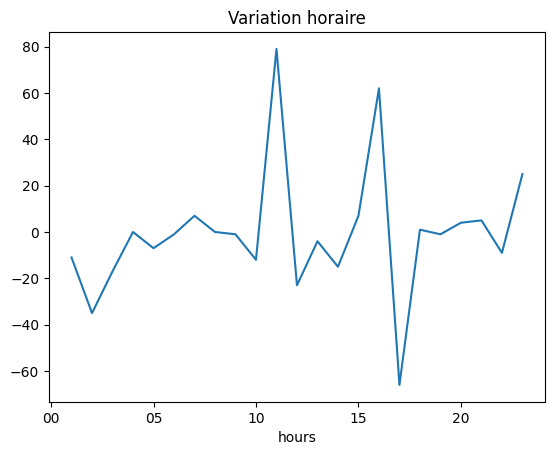

In [267]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [268]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [269]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.750676
min        0.418000
25%        3.082500
50%        3.435000
75%        3.773500
max        4.886000
Name: kWh, dtype: float64

In [270]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [271]:
n, np.nanmean(df_grp.tail(n))

(303, np.float64(3.3003300330033003))

Text(0.5, 1.0, '303 days')

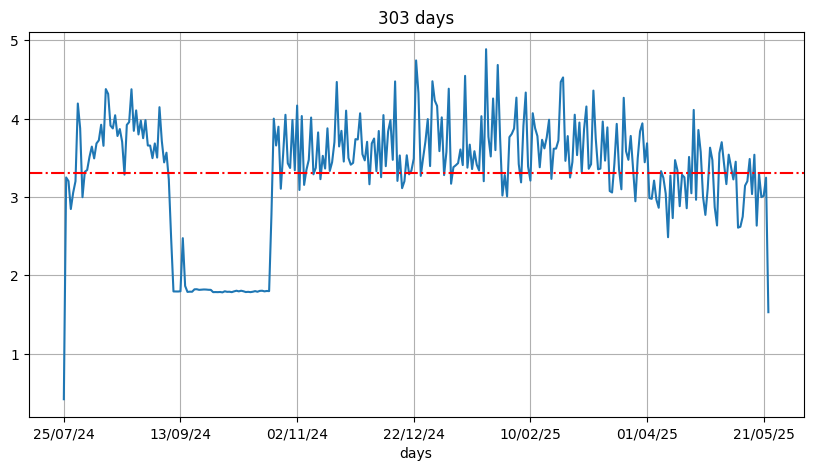

In [272]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

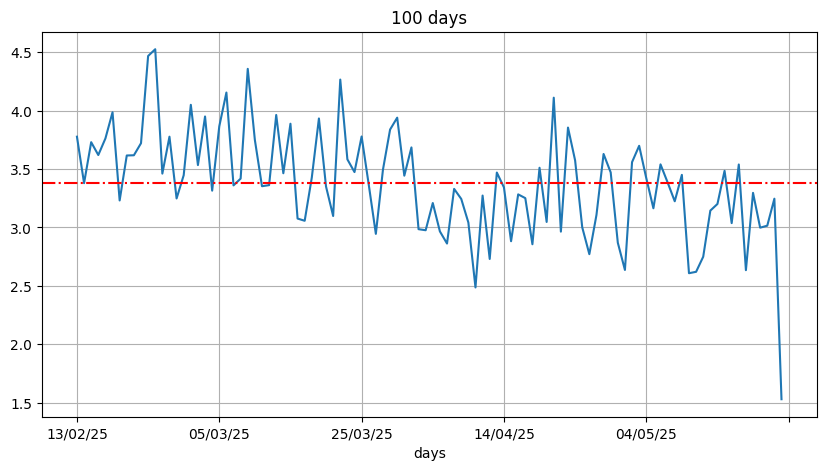

In [273]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [274]:
np.nanmean(df_grp.tail(span))

np.float64(3.3818599999999996)

In [275]:
df_grp['kWh']

days
25/07/24    0.418
26/07/24    3.249
27/07/24    3.202
28/07/24    2.846
29/07/24    3.054
            ...  
19/05/25    3.296
20/05/25    2.998
21/05/25    3.015
22/05/25    3.246
23/05/25    1.529
Name: kWh, Length: 303, dtype: float64

In [276]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.750676
min,0.418000
25%,3.082500
50%,3.435000
75%,3.773500
max,4.886000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

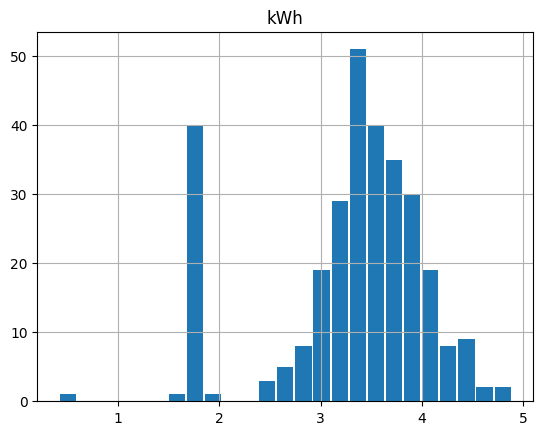

In [277]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [278]:
df_grp.tail(span)['kWh']

days
13/02/25    3.777
14/02/25    3.379
15/02/25    3.730
16/02/25    3.620
17/02/25    3.762
            ...  
19/05/25    3.296
20/05/25    2.998
21/05/25    3.015
22/05/25    3.246
23/05/25    1.529
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [279]:
day

'23/05/25'

In [280]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,117,117,NaN
01,101,218,-16.0
02,100,318,-1.0
03,101,419,1.0
04,102,521,1.0
05,99,620,-3.0
06,99,719,0.0
07,98,817,-1.0
08,100,917,2.0


In [281]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


14

In [282]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 15)

In [283]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [284]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [285]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
Name: days, dtype: float64

In [286]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [287]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 00 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     14 non-null     int64  
 1   cumsum  14 non-null     int64  
 2   diff    13 non-null     float64
 3   days    14 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 560.0+ bytes


In [288]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
Name: days, dtype: float64

In [289]:
day

'23/05/25'

In [290]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,117,117,NaN,1.0
01,101,218,-16.0,2.0
02,100,318,-1.0,3.0
03,101,419,1.0,4.0
04,102,521,1.0,5.0
05,99,620,-3.0,6.0
06,99,719,0.0,7.0
07,98,817,-1.0,8.0
08,100,917,2.0,9.0


In [291]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_4304\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(1529)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '23/05/25: kWh    1529\ndtype: int64')

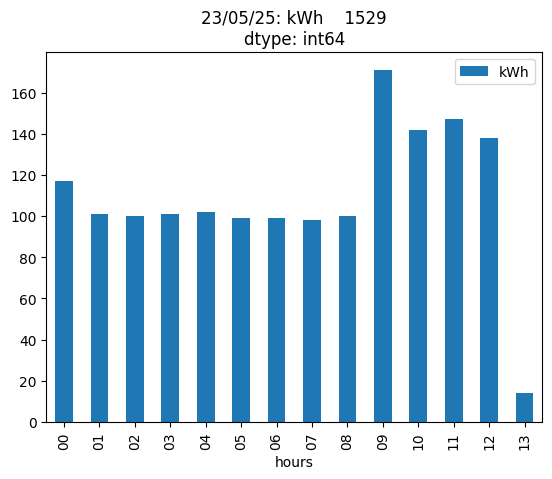

In [292]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [293]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13'],
      dtype='object', name='hours')

# Conso du jour


In [294]:

grp_by_dayhours.count()

kWh       7241
cumsum    7241
diff      6938
days        14
dtype: int64

'22/01/25'

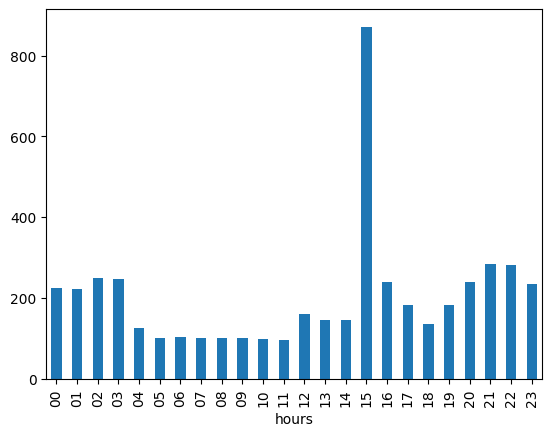

In [295]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [296]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [297]:
df_grp.tail(7)['kWh']

days
17/05/25    3.539
18/05/25    2.634
19/05/25    3.296
20/05/25    2.998
21/05/25    3.015
22/05/25    3.246
23/05/25    1.529
Name: kWh, dtype: float64

Total= 338.186 , Moyenne= 3.3818599999999996


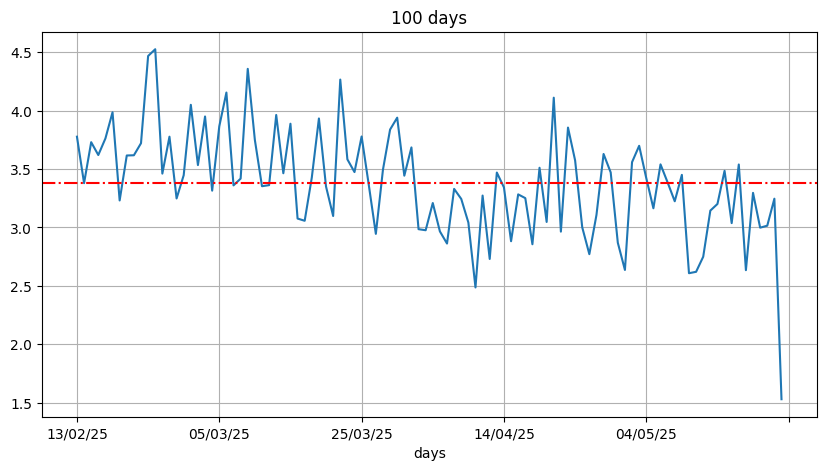

In [298]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [299]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 13:08:17, Minutes in day: 788


In [300]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [301]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:42.43


In [302]:
end - start

102.42809796333313

In [303]:
#df = conso_day
show_tranches()

2
2025-05-23 00:00:21.087334	2025-05-23 09:16:58.848334	9h 16m 37s 	1000
2025-05-23 09:16:58.848334	2025-05-23 13:06:39.707334	3h 49m 40s 	529


# Today

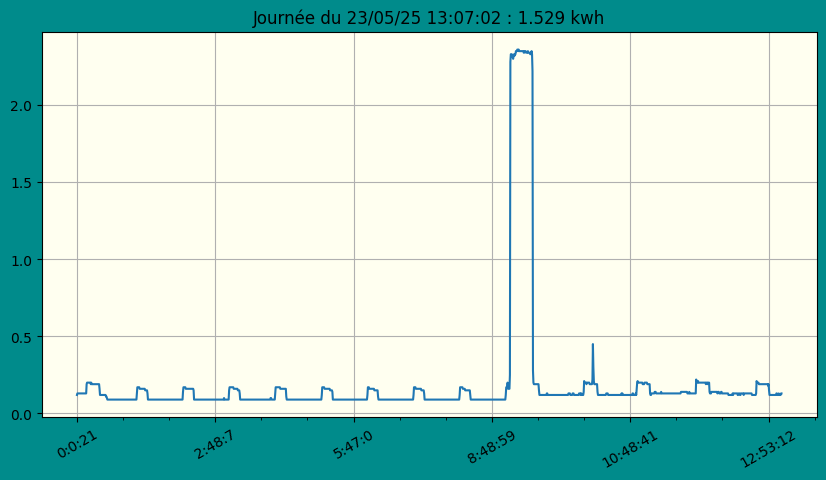

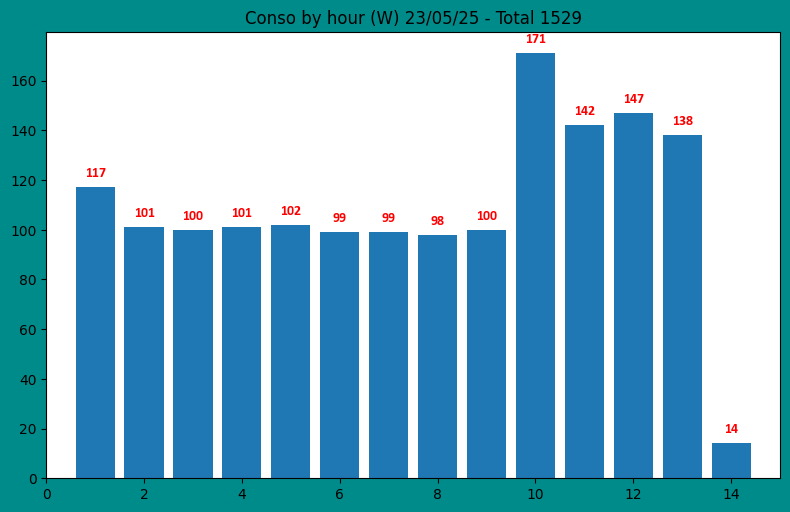

In [304]:
show(today,bgcolor='ivory')
conso_by_hour(today)

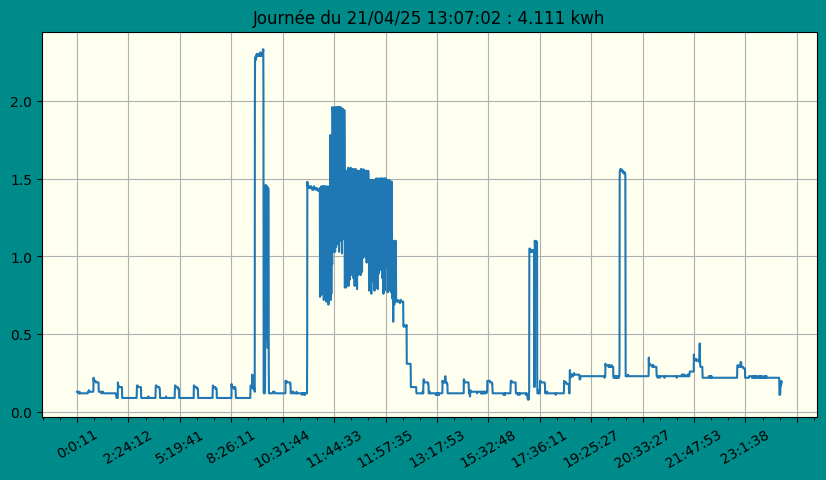

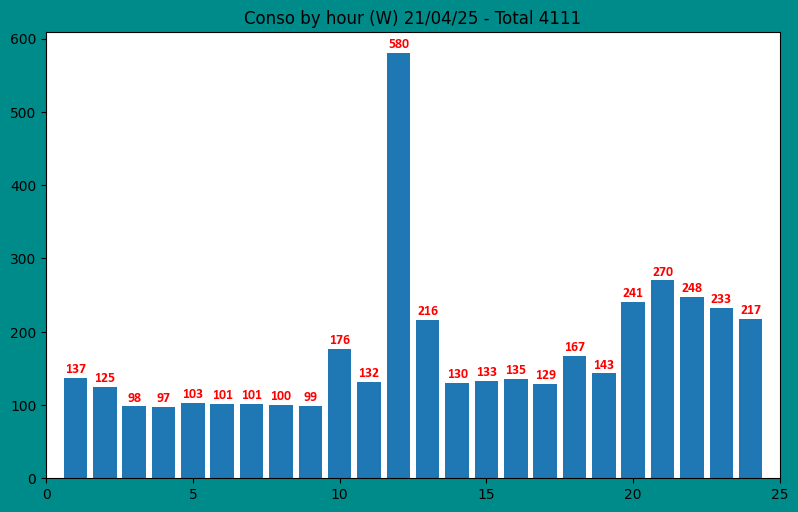

In [305]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4886)

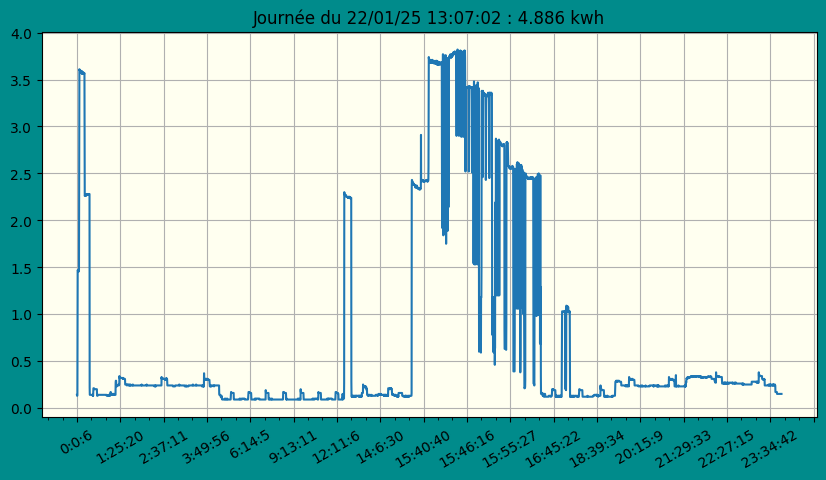

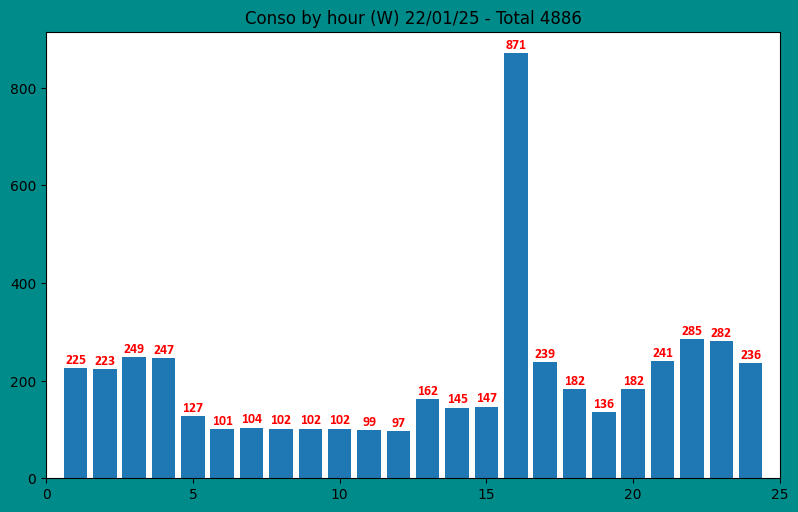

In [306]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

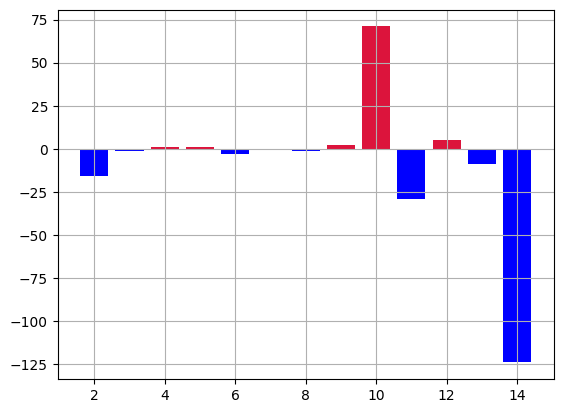

In [307]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

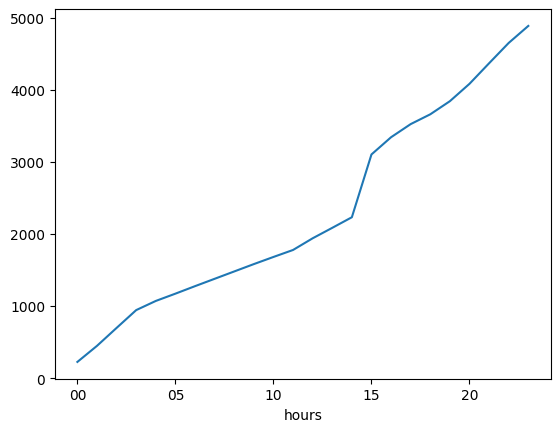

In [308]:
data.cumsum().plot()


<Axes: xlabel='hours'>

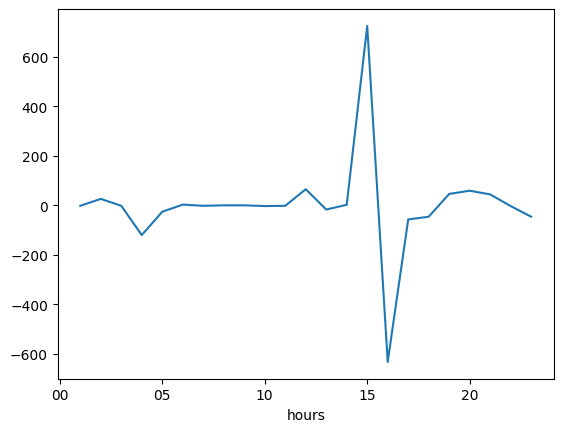

In [309]:
# evolution par heure
data.diff().plot()

In [310]:
data.diff().describe()

count     23.000000
mean       0.478261
std      208.775841
min     -632.000000
25%      -21.500000
50%       -2.000000
75%       14.500000
max      724.000000
Name: kWh, dtype: float64

<Axes: >

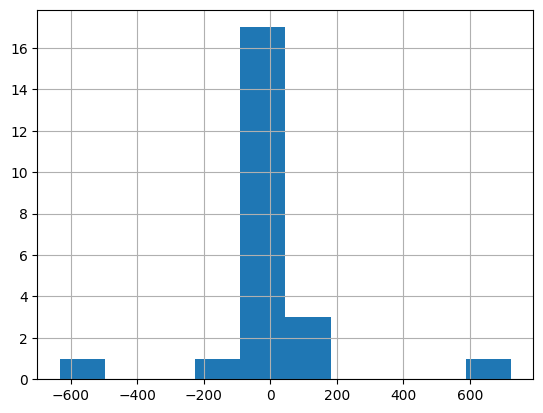

In [311]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [312]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo

# list store files csv


In [313]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

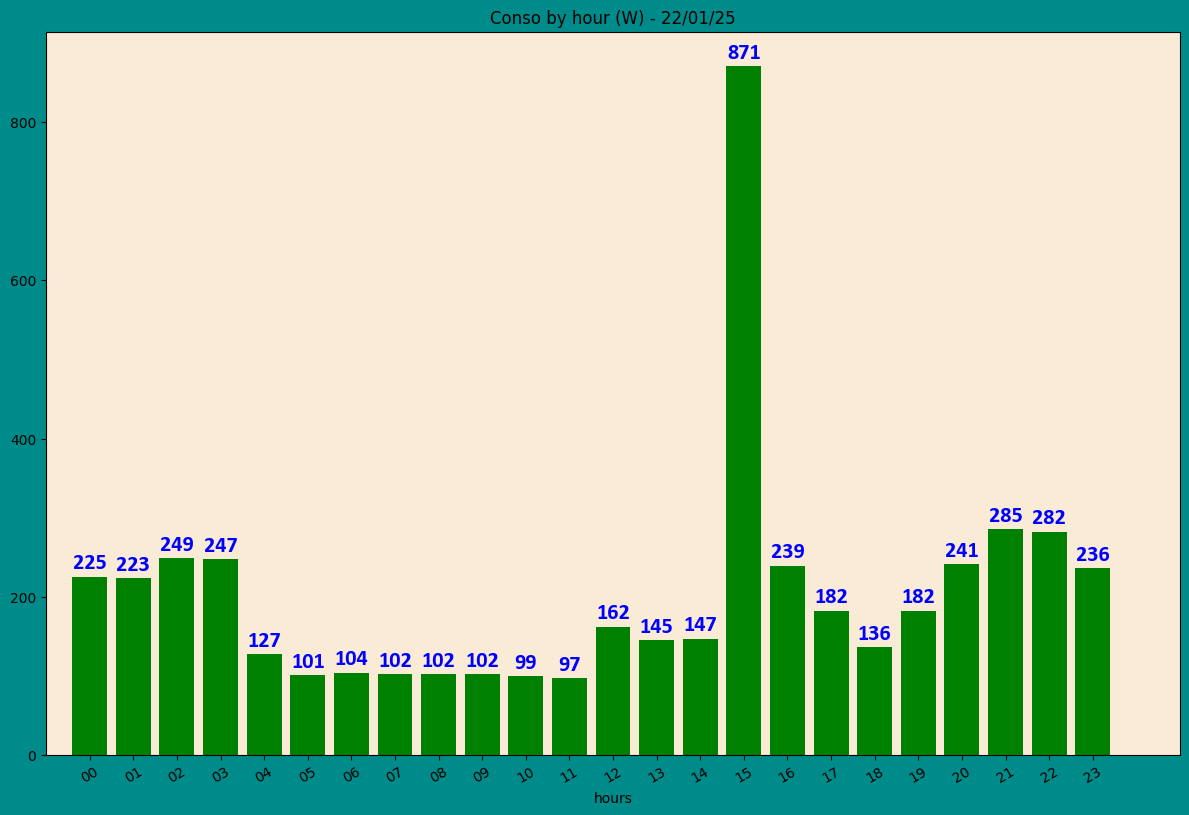

In [314]:
day,conso_byhour(day)

In [315]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


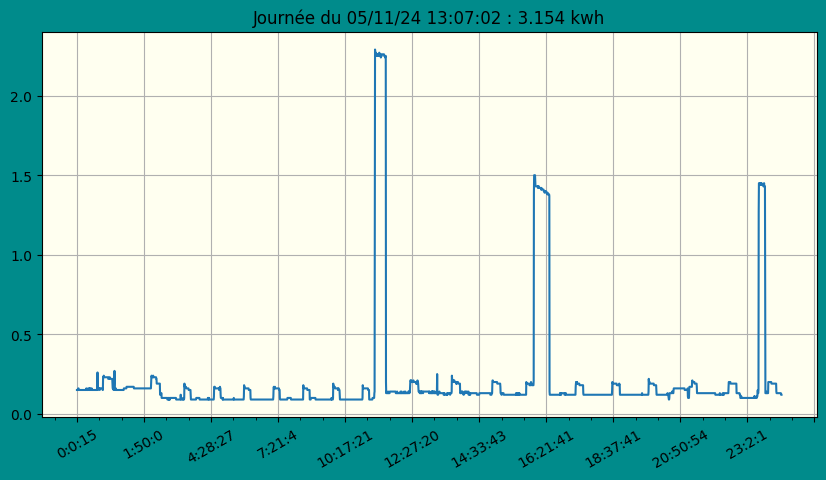

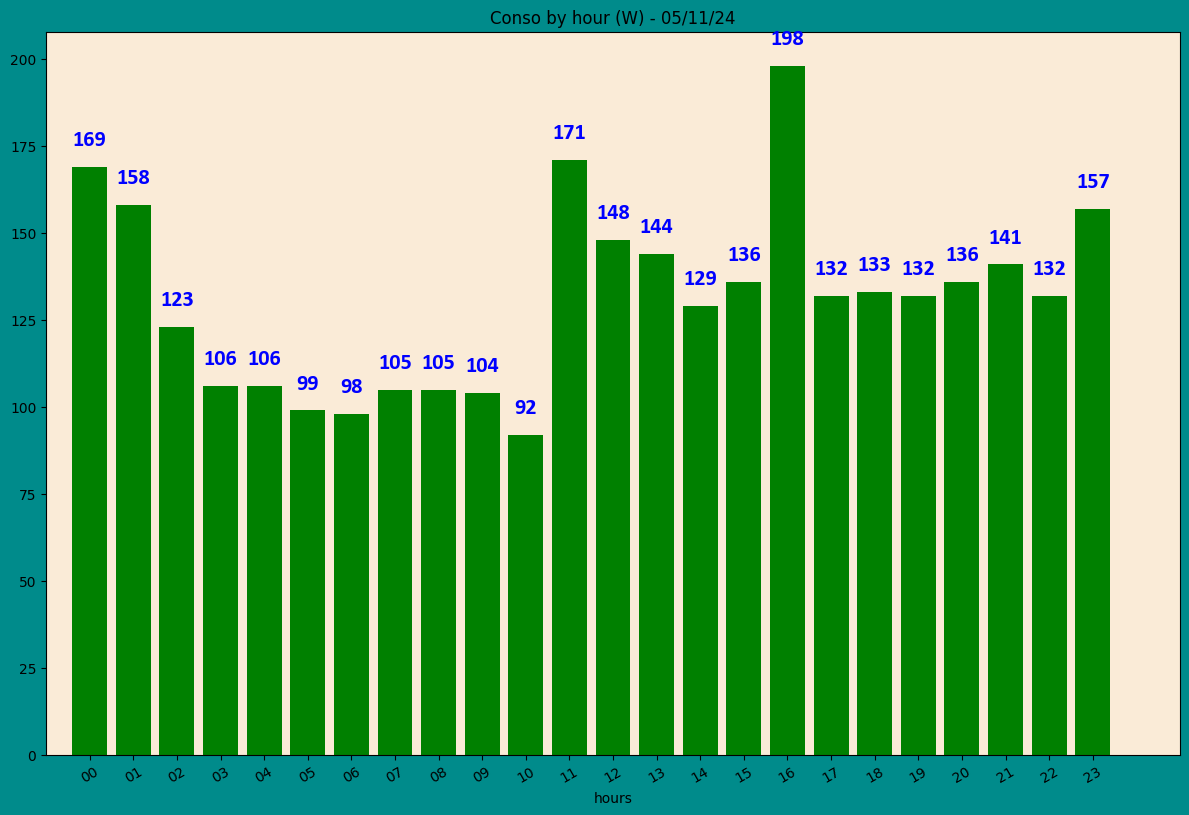

In [316]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [317]:
month

,day,hours,months,kWh
833037,01,00,2025-04,0.20
833038,01,00,2025-04,0.20
833039,01,00,2025-04,0.20
833040,01,00,2025-04,0.20
833041,01,00,2025-04,0.20
...,...,...,...,...
928815,30,23,2025-04,0.09
928816,30,23,2025-04,0.09
928817,30,23,2025-04,0.09
928818,30,23,2025-04,0.09


In [318]:
month.describe()


,kWh
count,95783.000000
mean,0.310162
std,0.548036
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

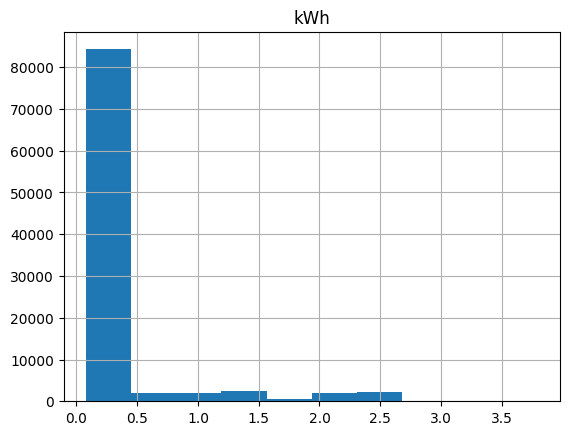

In [319]:
month.hist()

<Axes: >

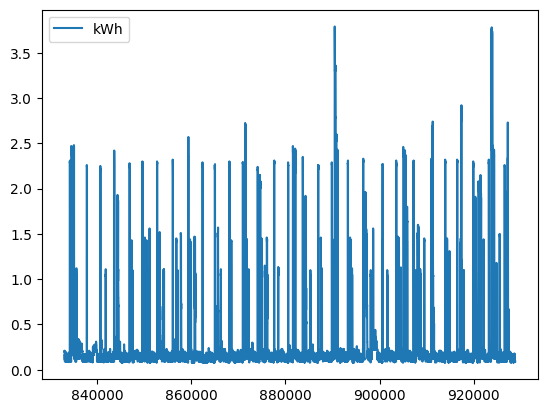

In [320]:
month.plot()

In [321]:
# index with max conso in this month
month.idxmax().kWh

np.int64(890485)

In [322]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       925951
hours     836517
months    833037
kWh       890485
dtype: int64

In [323]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [324]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
25/07/24 21     130     130    NaN   NaN
         22     140     270   10.0   NaN
         23     148     418    8.0   NaN
26/07/24 00     149     149    NaN   NaN
         01     147     296   -2.0   NaN
...             ...     ...    ...   ...
23/05/25 09     171    1088   71.0  10.0
         10     142    1230  -29.0  11.0
         11     147    1377    5.0  12.0
         12     138    1515   -9.0  13.0
         13      14    1529 -124.0  14.0

[7241 rows x 4 columns]

In [325]:
month

,day,hours,months,kWh
833037,01,00,2025-04,0.20
833038,01,00,2025-04,0.20
833039,01,00,2025-04,0.20
833040,01,00,2025-04,0.20
833041,01,00,2025-04,0.20
...,...,...,...,...
928815,30,23,2025-04,0.09
928816,30,23,2025-04,0.09
928817,30,23,2025-04,0.09
928818,30,23,2025-04,0.09


In [326]:
month.idxmax()


day       925951
hours     836517
months    833037
kWh       890485
dtype: int64

In [327]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 890485, dtype: object

In [328]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       170
          01       128
          02       114
          03       110
          04       106
          05       103
          06       111
          07       110
          08       104
          09       103
          10       166
          11       144
          12       142
          13       139
          14       202
          15       142
          16       153
          17       185
          18       155
          19       147
          20       142
          21       172
          22       226
          23       173
Name: kWh, dtype: int64

In [329]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

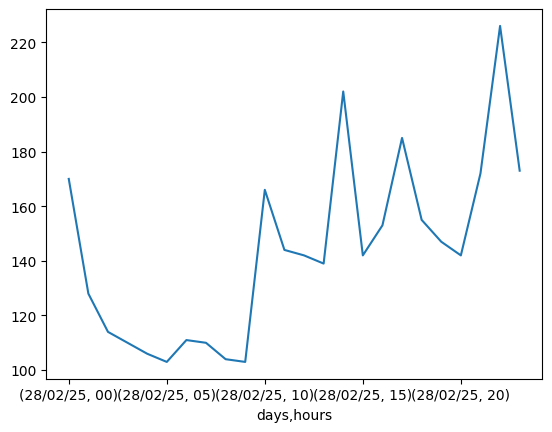

In [330]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [331]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [332]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [333]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [334]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB